# Dependences, Packages and Utilities

In [ ]:
!pip install descartes

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas
import numpy as np
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from shapely import wkt
from shapely.geometry import Polygon, Point, MultiPolygon
from descartes.patch import PolygonPatch
from pandas import DataFrame
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

Utility Functions

In [ ]:
def corr_plotter(corr):
  plt.figure(figsize=(14, 8))
  sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
  plt.title('Correlation Matrix')
  plt.show()

def find_neighbors(df):
    # Initialize an empty list to hold the list of neighbors for each row
    neighbors = []
    for index, row in df.iterrows():
        # Neighbors are those geometries that touch the geometry of the current row
        # Now, instead of using the index, use 'microcode' from the neighbors
        neighbors_microcode = df[df.geometry.touches(row['geometry'])]['microcode'].tolist()
        # Remove the microcode of the current row from the list, if present
        neighbors_microcode = [mc for mc in neighbors_microcode if mc != row['microcode']]
        neighbors.append(neighbors_microcode)
    return neighbors


def calculate_neighbors_potential(row, zones_df):
    # Initialize the sum of potentials
    neighbors_potential = 0
    # Loop through each neighbor's microcode in the neighbors list
    for neighbor_microcode in row['neighbors']:
        # Find the neighbor's zone potential and add it to the sum
        neighbors_potential += zones_df.loc[zones_df['microcode'] == neighbor_microcode, 'zone_potential'].sum()
    return neighbors_potential

def find_optimal_k(data, max_k=10):
    wcss = []

    for i in range(1, max_k+1):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)

    # Plotting the results onto a line graph to observe the 'Elbow'
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, max_k+1), wcss, marker='o', linestyle='--')
    plt.title('Elbow Method for Optimal K')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

# Loading Datasets & Data Cleaning

Loading Datasets

In [ ]:
gravitation = pandas.read_csv('drive/MyDrive/Fater/Raw/gravitation_NA.csv')
shapes = pandas.read_csv('drive/MyDrive/Fater/Raw/shapes_NA.csv')
socio_demo = pandas.read_csv('drive/MyDrive/Fater/Raw/socio_demo_NA.csv')
stores = pandas.read_csv('drive/MyDrive/Fater/Raw/stores_NA.csv')
stores_with_microcode = pandas.read_csv('drive/MyDrive/Fater/Processed/stores_with_microcode.csv')

Filling missing values

In [ ]:
gravitation['media_annuale'] = gravitation.groupby(['daytype', 'fasciaoraria', 'datatype'])['media_annuale'].transform(lambda x: x.fillna(x.median()))

Removing Unnecessary Columns

In [ ]:
try:
  socio_demo = socio_demo.drop(columns=['province', 'region'])
  stores_with_microcode = stores_with_microcode.drop(columns=['Provincia', 'Lat', 'Long', 'Indirizzo', 'Unnamed: 0'])
except:
  print('Columns Already Removed!')

# Feature Creating

Pivoting Gravitation

In [ ]:
datatypes = ['F1', 'F2', 'F3', 'F4', 'F5', 'F6']
baby_diaper_revenue = 46.5
adult_diaper_revenue = 15.2

gravitation = gravitation.groupby('microcode').apply(lambda x: pandas.Series({
    'total_media_annuale': x.loc[x['datatype'].isin(datatypes), 'media_annuale'].sum(),
    'F1_media_annuale': x.loc[x['datatype'] == 'F1', 'media_annuale'].sum(),
    'F2_media_annuale': x.loc[x['datatype'] == 'F2', 'media_annuale'].sum(),
    'F3_media_annuale': x.loc[x['datatype'] == 'F3', 'media_annuale'].sum(),
    'F4_media_annuale': x.loc[x['datatype'] == 'F4', 'media_annuale'].sum(),
    'F5_media_annuale': x.loc[x['datatype'] == 'F5', 'media_annuale'].sum(),
    'F6_media_annuale': x.loc[x['datatype'] == 'F6', 'media_annuale'].sum(),
    'GF_media_annuale': x.loc[x['datatype'] == 'Gf', 'media_annuale'].sum(),
    'GM_media_annuale': x.loc[x['datatype'] == 'Gm', 'media_annuale'].sum(),
})).reset_index()

Adding Population Score to the Socio Demo NA

In [ ]:
socio_demo['population_score'] = socio_demo['population_age_65_up_yr'] * adult_diaper_revenue + socio_demo['population_age_00_04_yr'] * baby_diaper_revenue

Adding Neighbors to Shapes

In [ ]:
shapes['geometry'] = shapes['geometry'].apply(wkt.loads)
shapes_gdp = gpd.GeoDataFrame(shapes, geometry='geometry')

shapes['neighbors'] = find_neighbors(shapes_gdp)

In [ ]:
shapes.to_csv('shapes.csv')
gravitation.to_csv('gravitations.csv')
socio_demo.to_csv('socio_demo.csv')
stores_with_microcode.to_csv('stores.csv')

# Creating Zone Based Dataframe

In [ ]:
groupped_stores = stores_with_microcode.groupby(['microcode'])['Potenziale'].sum().reset_index()
groupped_stores.columns = ['microcode', 'zone_potential']

# Step 2: Calculate the number of stores per microcode (zone)
store_counts = stores_with_microcode.groupby('microcode').size().reset_index(name='store_count')

# Step 3: Merge the store counts with the sum of potentials
groupped_stores = groupped_stores.merge(store_counts, on='microcode')

In [ ]:
zones_df = pandas.merge(socio_demo[['population_score', 'microcode', 'district']], gravitation[['microcode','total_media_annuale']], on='microcode', how='inner')
zones_df = pandas.merge(zones_df, groupped_stores, on='microcode', how='inner')
zones_df = pandas.merge(zones_df, shapes[['microcode', 'neighbors']], on='microcode')

zones_df['neighbors_potential'] = zones_df.apply(calculate_neighbors_potential, args=(zones_df,), axis=1)

In [ ]:
!pip install scikit-learn

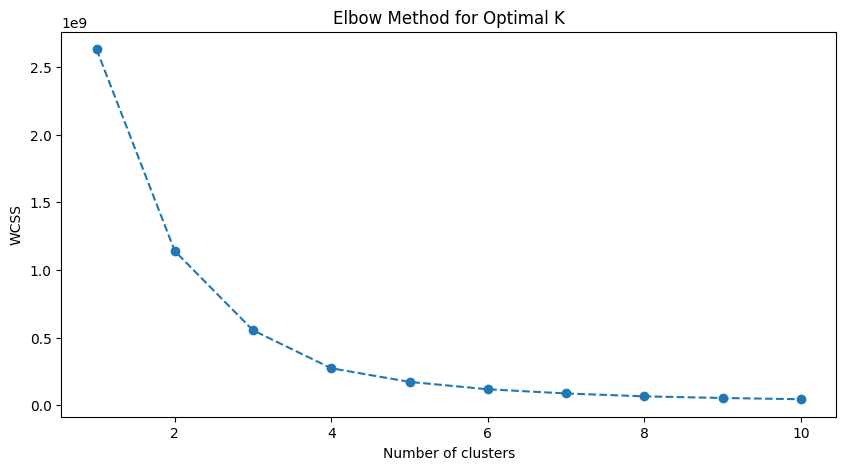

In [ ]:
x = zones_df[['population_score']].values
find_optimal_k(x) # k=4

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=42).fit(x)
zones_df['population_class'] = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Encode district by zone_potential

In [ ]:
average_potential_district = zones_df.groupby('district')['zone_potential'].mean().sort_values(ascending=False)

# Create a ranking based on average potential
ranking_district = average_potential_district.rank(method='dense', ascending=False).astype(int)
ranking_district = (len(ranking_district) - ranking_district + 1).astype(int)


zones_df['district_encoded'] = zones_df['district'].map(ranking_district.to_dict())

In [ ]:
try:
  zones_df = zones_df.drop(columns=['district', 'neighbors'])
except:
  print('Columns Already Removed!')

In [ ]:
print(zones_df.columns)

Index(['population_score', 'microcode', 'total_media_annuale',
       'zone_potential', 'store_count', 'neighbors_potential',
       'population_class', 'district_encoded'],
      dtype='object')


# Creating Store Based Dataframe

Encoding Comune

In [ ]:
average_potential_comune = stores_with_microcode.groupby('Comune')['Potenziale'].mean().sort_values(ascending=False)

# Create a ranking based on average potential
ranking_comune = average_potential_comune.rank(method='dense', ascending=False).astype(int)
ranking_comune = (len(ranking_comune) - ranking_comune + 1).astype(int)
# Map the ranking to the original dataframe for label encoding
stores_with_microcode['Comune_encoded'] = stores_with_microcode['Comune'].map(ranking_comune.to_dict())

Encoding Tipologia

In [ ]:
# Group by 'TipologiaPdV' and calculate average potential for each type
average_potential = stores_with_microcode.groupby('TipologiaPdV')['Potenziale'].mean().sort_values(ascending=False)

# Create a ranking based on average potential
ranking = average_potential.rank(method='dense', ascending=False).astype(int)
ranking = (len(ranking) - ranking + 1).astype(int)
# Map the ranking to the original dataframe for label encoding
stores_with_microcode['TipologiaPdV_encoded'] = stores_with_microcode['TipologiaPdV'].map(ranking.to_dict())

Encoding Insegna

In [ ]:
# Group by 'Insegna' and calculate average potential for each
average_potential_insegna = stores_with_microcode.groupby('Insegna')['Potenziale'].mean().sort_values(ascending=False)

# Create a ranking based on average potential
ranking_insegna = average_potential_insegna.rank(method='dense', ascending=False).astype(int)
ranking_insegna = (len(ranking_insegna) - ranking_insegna + 1).astype(int)


stores_with_microcode['Insegna_encoded'] = stores_with_microcode['Insegna'].map(ranking_insegna.to_dict())

Encoding Parking

In [ ]:
stores_with_microcode['Parking'] = stores_with_microcode['Parking'].astype(int)

Extracting required columns

In [ ]:
stores_df = stores_with_microcode[['Cod3HD', 'Potenziale', 'microcode', 'Comune_encoded', 'Insegna_encoded', 'MQVEND', 'Parking', 'TipologiaPdV_encoded']]

In [ ]:
print(stores_df.columns)

Index(['Cod3HD', 'Potenziale', 'microcode', 'Comune_encoded',
       'Insegna_encoded', 'MQVEND', 'Parking', 'TipologiaPdV_encoded'],
      dtype='object')


# Merging Dataframes

In [ ]:
merged_df = pandas.merge(zones_df, stores_df, on='microcode', how='inner')

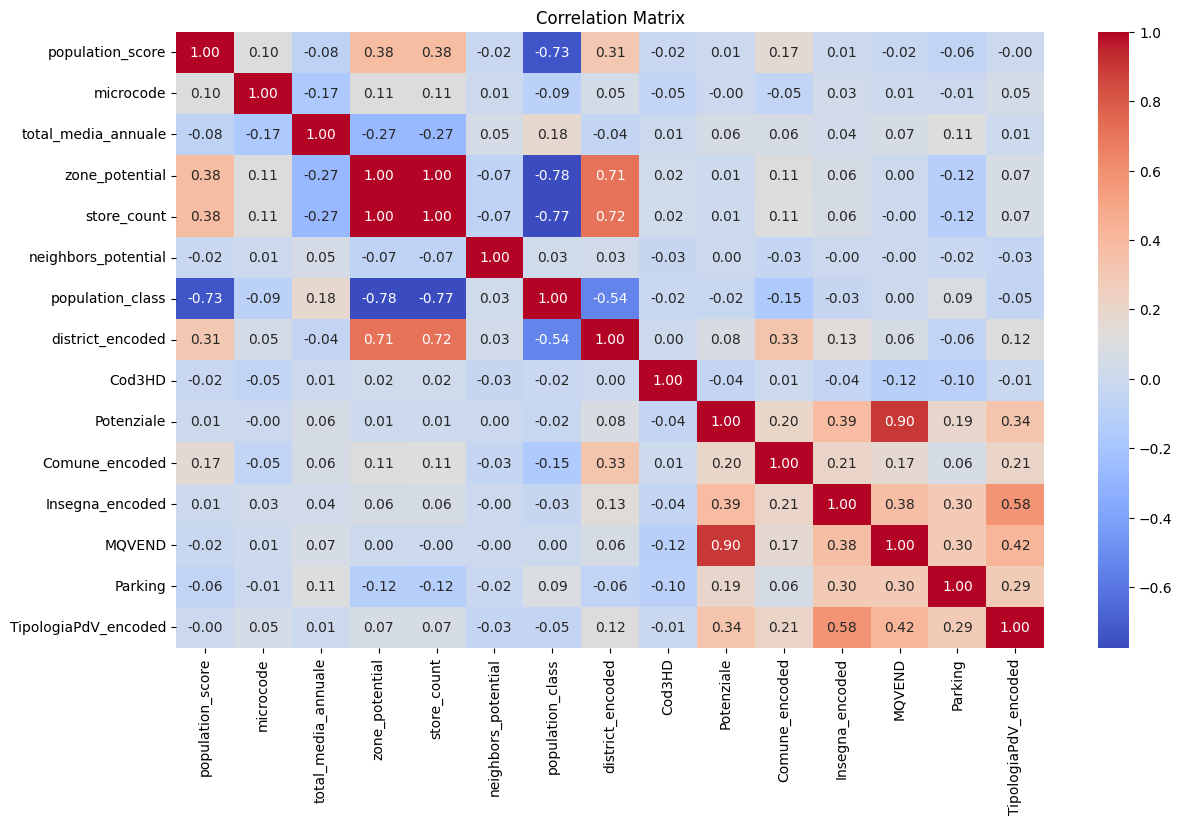

In [ ]:
corr_plotter(merged_df.corr())

Removing Overfit Columns

In [ ]:
try:
  merged_df = merged_df.drop(columns=['neighbors_potential'])
except:
  print('Column Already Removed!')

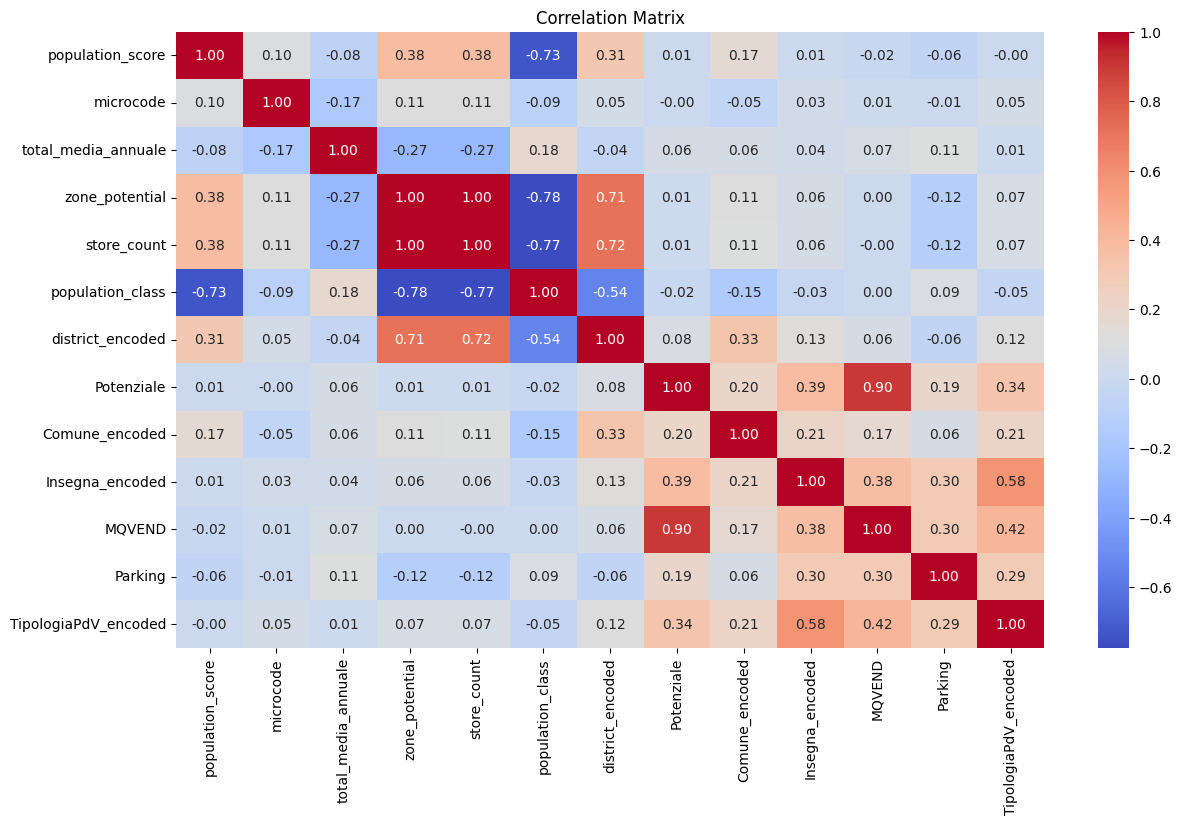

In [ ]:
merged_df = merged_df.drop(columns=['Cod3HD'])
corr_plotter(merged_df.corr())

In [ ]:
X_zone = merged_df.drop('Potenziale', axis=1)
y_zone = merged_df['Potenziale']

X_train_zone, X_test_zone, y_train_zone, y_test_zone = train_test_split(X_zone, y_zone, test_size=0.3, random_state=42)

model_zone = RandomForestRegressor(random_state=42)
model_zone.fit(X_train_zone, y_train_zone)


zone_predictions = model_zone.predict(X_test_zone)

# Mean Squared Error
mse_zone = mean_squared_error(y_test_zone, zone_predictions)
print(f"Mean Squared Error: {mse_zone}")

# Root Mean Squared Error
rmse_zone = np.sqrt(mse_zone)
print(f"Root Mean Squared Error: {rmse_zone}")

# R^2 Score
r2_zone = r2_score(y_test_zone, zone_predictions)
print(f"R^2 Score: {r2_zone}")

# Custom Regression "Accuracy" (Example: within a certain percentage of the true value)
accuracy_threshold = 0.25
accurate_predictions = np.abs(y_test_zone - zone_predictions) <= accuracy_threshold * y_test_zone
custom_accuracy_zone = np.mean(accurate_predictions)
print(f"Custom Regression \"Accuracy\": {custom_accuracy_zone}")

Mean Squared Error: 0.000634490887913133
Root Mean Squared Error: 0.02518910256267843
R^2 Score: 0.8311556770134728
Custom Regression "Accuracy": 0.45144356955380577


In [ ]:
# Feature importance report
feature_importances = model_zone.feature_importances_
features = X_zone.columns
importances = zip(features, feature_importances)
sorted_importances = sorted(importances, key=lambda x: x[1], reverse=True)

print("Feature Importances:")
for feature, importance in sorted_importances:
    print(f"{feature}: {importance}")

Feature Importances:
Insegna_encoded: 0.5724459054002119
MQVEND: 0.26499983280785616
TipologiaPdV_encoded: 0.08866885671969398
Comune_encoded: 0.04076788856033855
total_media_annuale: 0.007655482295197377
zone_potential: 0.007178245491033629
population_score: 0.005300018503693835
Parking: 0.0032769452289461536
microcode: 0.002936755092131363
store_count: 0.002640019535546785
district_encoded: 0.0025725408020342505
population_class: 0.0015575095633160688


In [ ]:
# Calculate the total store potential within each zone if not already calculated
zone_total_store_potential = stores_with_microcode.groupby('microcode')['Potenziale'].sum().reset_index()
zone_total_store_potential.columns = ['microcode', 'total_zone_store_potential']

# Merge this back with store_df to calculate ratios
store_df = stores_with_microcode.merge(zone_total_store_potential, on='microcode')
store_df['store_potential_ratio'] = store_df['Potenziale'] / store_df['total_zone_store_potential']

# Now, prepare your features for the store model, including features from zone_df
# This might involve merging data from zone_df into store_df based on zone_id
X_store = store_df.drop(['Potenziale', 'store_potential_ratio'], axis=1)
y_store = store_df['store_potential_ratio']

X_train_store, X_test_store, y_train_store, y_test_store = train_test_split(X_store, y_store, test_size=0.3, random_state=42)

model_store = RandomForestRegressor(random_state=42)
model_store.fit(X_train_store, y_train_store)

ValueError: could not convert string to float: "QUARI'"

In [ ]:
!pip install mapclassify

In [ ]:
shapes['geometry'] = shapes['geometry']
# shapes['geometry'] = shapes['geometry'].apply(wkt.loads)
gdf_shapes = gpd.GeoDataFrame(shapes, geometry='geometry')


# Define the variables
baby_diaper_revenue = 46.5
baby_diaper_CAGR = 1.043

adult_diaper_revenue = 15.2
adult_diaper_CAGR = 1.068

socio_demo['Population Score'] = socio_demo['population_age_65_up_yr'] * adult_diaper_revenue + socio_demo['population_age_00_04_yr'] * baby_diaper_revenue
socio_demo['Population Score 3'] = socio_demo['population_age_65_up_yr'] * (adult_diaper_revenue * np.power(adult_diaper_CAGR, 3)) + socio_demo['population_age_00_04_yr'] * (baby_diaper_revenue * np.power(baby_diaper_CAGR, 3))
socio_demo['Population Score 10'] = socio_demo['population_age_65_up_yr'] * (adult_diaper_revenue * np.power(adult_diaper_CAGR, 10)) + socio_demo['population_age_00_04_yr'] * (baby_diaper_revenue * np.power(baby_diaper_CAGR, 10))


merged_df = pandas.merge(socio_demo, gdf_shapes, on='microcode')


gdf = gpd.GeoDataFrame(merged_df, geometry='geometry')



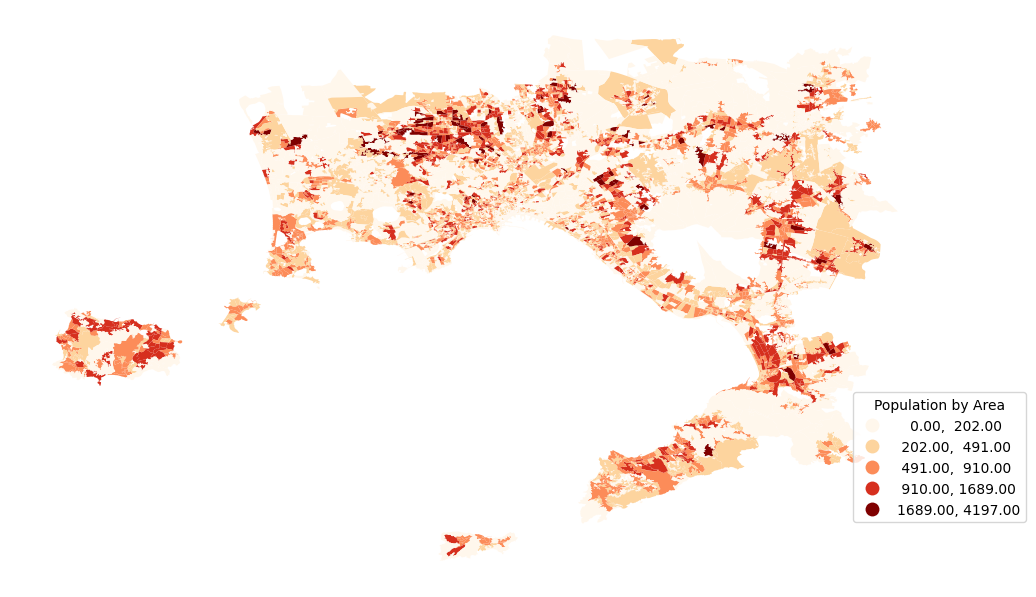

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
gdf.plot(column='population', ax=ax, legend=True, cmap='OrRd', scheme='fisher_jenks',
         legend_kwds={'title': "Population by Area",'loc': 'lower right', 'bbox_to_anchor': (1.1, 0.1)})

plt.axis('off')
plt.show()

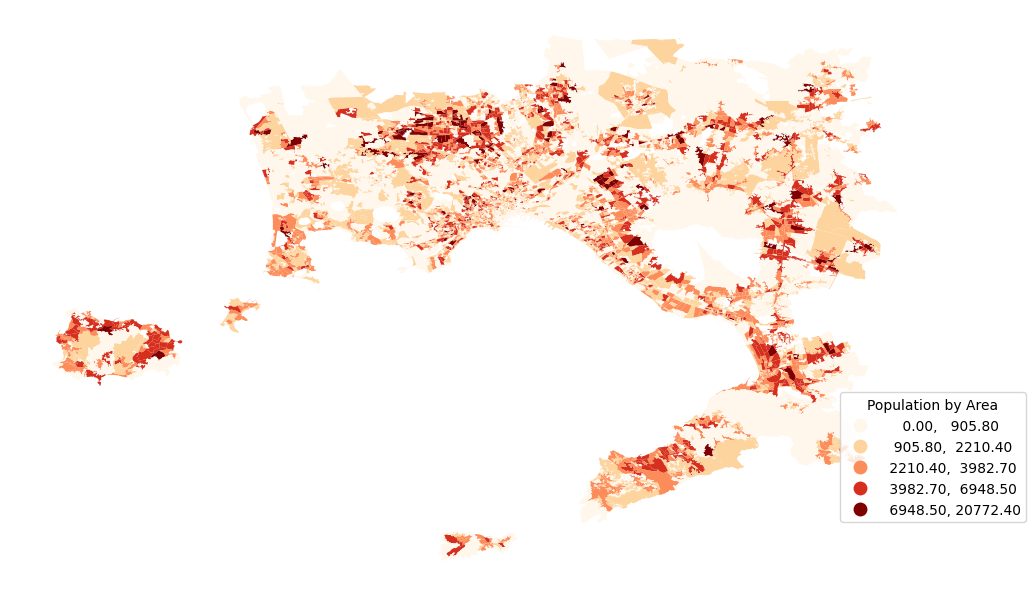

In [ ]:

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
gdf.plot(column='Population Score', ax=ax, legend=True, cmap='OrRd', scheme='fisher_jenks',
         legend_kwds={'title': "Population by Area",'loc': 'lower right', 'bbox_to_anchor': (1.1, 0.1)})

plt.axis('off')
plt.show()